<a href="https://colab.research.google.com/github/DanAkarca/modular_experts/blob/main/latent_programme_search_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Epoch [0/100], Loss: 1033.7931
Epoch [10/100], Loss: 265.9757
Epoch [20/100], Loss: 176.4571
Epoch [30/100], Loss: 108.1005
Epoch [40/100], Loss: 69.4930
Epoch [50/100], Loss: 55.7202
Epoch [60/100], Loss: 47.8223
Epoch [70/100], Loss: 37.9204
Epoch [80/100], Loss: 31.7264
Epoch [90/100], Loss: 17.5179


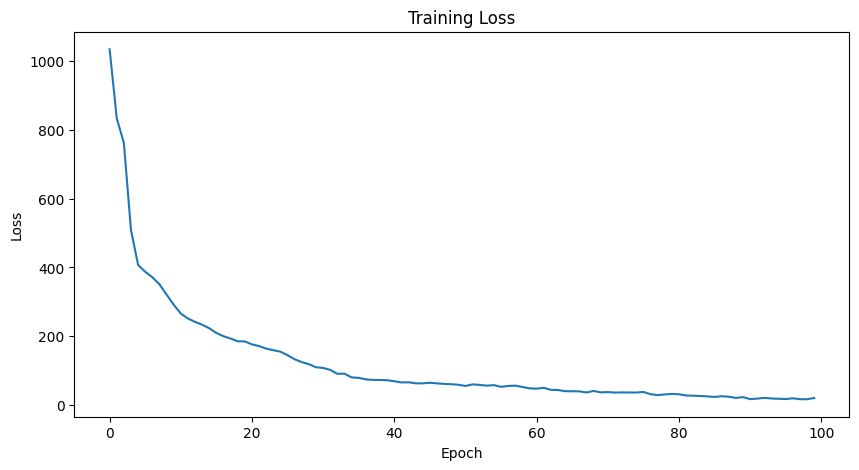

Latent search step 0, Loss: 1.6153
Latent search step 20, Loss: 0.0952
Latent search step 40, Loss: 0.0520
Latent search step 60, Loss: 0.0322
Latent search step 80, Loss: 0.0234


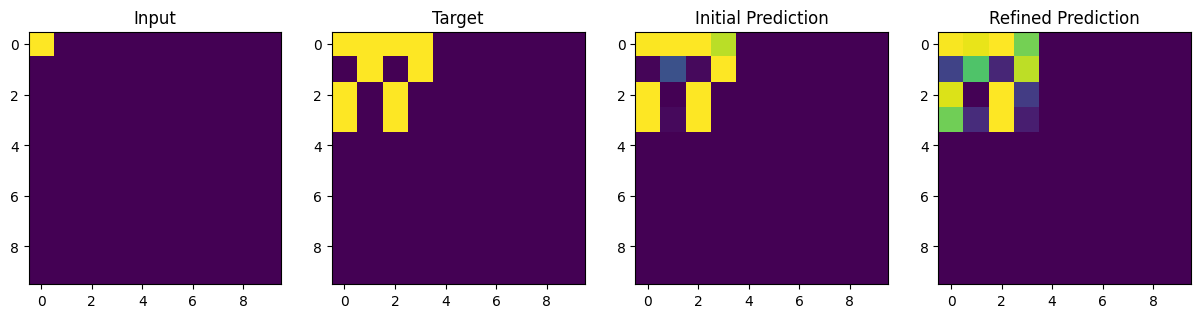

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class LPN(nn.Module):
    def __init__(self, input_size=10, latent_dim=32):
        super().__init__()

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(2 * input_size * input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        # Mean and log variance for the latent space
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_var = nn.Linear(128, latent_dim)

        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + input_size * input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, input_size * input_size),
            nn.Sigmoid()
        )

        self.input_size = input_size

    def encode(self, x, y):
        # Concatenate input and output
        xy = torch.cat([x.flatten(1), y.flatten(1)], dim=1)
        h = self.encoder(xy)

        # Get latent parameters
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)

        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, x, z):
        # Ensure tensors are on the same device
        z = z.to(x.device)
        # Concatenate input with latent code
        xz = torch.cat([x.flatten(1), z], dim=1)
        return self.decoder(xz).view(x.shape)

    def forward(self, x, y=None, z=None):
        if z is not None:
            # During inference with provided latent
            return self.decode(x, z)

        # During training
        mu, log_var = self.encode(x, y)
        z = self.reparameterize(mu, log_var)
        recon = self.decode(x, z)

        return recon, mu, log_var

def generate_pattern_data(batch_size=32, grid_size=10, pattern_size=4, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create empty grids
    inputs = torch.zeros(batch_size, grid_size, grid_size, device=device)
    outputs = torch.zeros(batch_size, grid_size, grid_size, device=device)

    for b in range(batch_size):
        # Random pattern
        pattern = torch.randint(0, 2, (pattern_size, pattern_size),
                              dtype=torch.float32, device=device)

        # Random position for marker in input
        pos_x = torch.randint(0, grid_size-pattern_size+1, (1,), device=device)
        pos_y = torch.randint(0, grid_size-pattern_size+1, (1,), device=device)

        # Place marker in input
        inputs[b, pos_x, pos_y] = 1.0

        # Place pattern in output
        outputs[b, pos_x:pos_x+pattern_size, pos_y:pos_y+pattern_size] = pattern

    return inputs, outputs

def loss_function(recon_x, x, mu, log_var, beta=1e-4):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + beta * KLD

def train(model, optimizer, device, num_epochs=100):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 100

        for _ in range(num_batches):
            # Generate new data
            x, y = generate_pattern_data(batch_size=32, device=device)

            # Forward pass
            recon, mu, log_var = model(x, y)

            # Compute loss
            loss = loss_function(recon, y, mu, log_var)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}')

    return losses

def latent_search(model, x, y, num_steps=100, lr=0.1):
    model.eval()
    # Initialize random latent vector with gradient tracking
    z = torch.randn((x.shape[0], model.fc_mu.out_features),
                    device=x.device, requires_grad=True)
    optimizer = optim.Adam([z], lr=lr)

    losses = []
    for step in range(num_steps):
        optimizer.zero_grad()

        # Forward pass
        pred = model(x, z=z)

        # Compute loss
        loss = nn.functional.binary_cross_entropy(pred, y)
        losses.append(loss.item())

        # Backward pass
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f'Latent search step {step}, Loss: {loss.item():.4f}')

    return z.detach()

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model and move to device
    model = LPN().to(device)
    optimizer = optim.Adam(model.parameters())

    # Train the model
    losses = train(model, optimizer, device)

    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Test the model
    model.eval()
    # Generate test data
    x_test, y_test = generate_pattern_data(batch_size=1, device=device)

    with torch.no_grad():
        # Get initial prediction (using encoded latent)
        initial_pred, _, _ = model(x_test, y_test)

    # Perform latent search
    z_refined = latent_search(model, x_test, y_test)

    with torch.no_grad():
        refined_pred = model(x_test, z=z_refined)

        # Move tensors to CPU for plotting
        x_test = x_test.cpu()
        y_test = y_test.cpu()
        initial_pred = initial_pred.cpu()
        refined_pred = refined_pred.cpu()

        # Plot results
        fig, axes = plt.subplots(1, 4, figsize=(15, 4))
        axes[0].imshow(x_test[0])
        axes[0].set_title('Input')
        axes[1].imshow(y_test[0])
        axes[1].set_title('Target')
        axes[2].imshow(initial_pred[0])
        axes[2].set_title('Initial Prediction')
        axes[3].imshow(refined_pred[0])
        axes[3].set_title('Refined Prediction')
        plt.show()

if __name__ == "__main__":
    main()